# Final Project
## By: Philip Spencer and Paul Jojy

# Exploring the effects of Quantization on Deep Learning
In this project, we will be exploring the effects of quantization on deep learning. This is an important topic in this field, as deep learning models are very large and can be inefficient to run on edge devices such as smart phones. ADD MORE LATER
    
## 0. Initialization and Configuration

In [1]:
#Required packages. Uncomment below lines if not in your system
#pip install torch
#pip install torchvision

In [2]:
#CV packages
import torch
from torchvision import models, datasets, transforms, utils

#Data presentation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Data handling
import numpy as np
import pandas as pd
import copy

#Utilities
import time
import os

### Configuration

In [3]:
#Any Folder/Preface for models here, you may need to change this or create the folder
modelFolderPath = "./Saved Models/"
#Bool, save models or not
saveModels = False
#Bool, load models or not
loadModels = True

In [4]:
#Configure notebook for the run
sns.set(rc={'figure.figsize':(5,4)})
plt.ion()

#Set cuda device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu' #Uncomment this line if you prefer cpu
print("Device:", device)

#This may help clear issues, uncomment as needed
torch.cuda.empty_cache()

#setup torch for training
torch.backends.cudnn.benchmark= True

#Set seed for reproducable results
torch.manual_seed(0)

Device: cuda:0


In [5]:
#Define hyperparameters, and more
BATCH_SIZE = 300
EPOCHS = 6
LEARNING_RATE = 0.001
VALIDATION_RATIO = 0.85
LR_GAMMA = 0.1 #lr decay rate
LR_STEP_SIZE_DECAY = int(EPOCHS/3.0) #base this off total epochs to allow for fine tuning

## 1. Download and Preprocess Data
We will be analyzing CIFAR-10 and MNIST for this experiment. The data must be downloaded, normalized, and augmented to maximize performance.

In [6]:
def datadownload():
    cifar_augmenter = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    cifar_train = datasets.CIFAR10('.',download=True, transform=cifar_augmenter)
    cifar_test = datasets.CIFAR10('.',train=False, transform=cifar_augmenter)
    
    mnist_augmenter = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=3), #Convert grayscale to RGB where R=G=B. This is because the model is pretrained on an RGB dataset (Imagenet)
        transforms.ToTensor()
    ])
    
    mnist_train = datasets.MNIST('.',download=True, transform=mnist_augmenter)
    mnist_test = datasets.MNIST('.',train=False, transform=mnist_augmenter)
    return (cifar_train,cifar_test),(mnist_train,mnist_test)
cifar,mnist = datadownload()

Files already downloaded and verified


In [7]:
cifar

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [8]:
mnist

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=3)
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=3)
                ToTensor()
            ))

## 2. Prepare Dataloaders

In [9]:
numClassesMnist = len(mnist[0].classes)
classesMnist = mnist[0].classes
classesNumericMnist = [numericClass for numericClass in range(len(classesMnist))]
numClassesCifar = len(cifar[0].classes)
classesCifar = cifar[0].classes
classesNumericCifar = [numericClass for numericClass in range(len(classesCifar))]

In [10]:
print(classesCifar,classesNumericCifar)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
#Prepare MNIST training data 
mnistTrainSplit, mnistValSplit = torch.utils.data.random_split(mnist[0], [VALIDATION_RATIO, 1-VALIDATION_RATIO])
mnist_train_loader = torch.utils.data.DataLoader(mnistTrainSplit, shuffle=True, batch_size=BATCH_SIZE)
mnist_val_loader = torch.utils.data.DataLoader(mnistValSplit, shuffle=True, batch_size=BATCH_SIZE)

dataloaders_mnist = {'train': mnist_train_loader,
                      'val': mnist_val_loader}

#Prepare MNIST testing data
mnist_test_loader = torch.utils.data.DataLoader(mnist[1], shuffle=True, batch_size=BATCH_SIZE)

In [12]:
#Split CIFAR training data 
cifarTrainSplit, cifarValSplit = torch.utils.data.random_split(cifar[0], [VALIDATION_RATIO, 1-VALIDATION_RATIO])
cifar_train_loader = torch.utils.data.DataLoader(cifarTrainSplit, shuffle=True, batch_size=BATCH_SIZE)
cifar_val_loader = torch.utils.data.DataLoader(cifarValSplit, shuffle=True, batch_size=BATCH_SIZE)

dataloaders_cifar = {'train': cifar_train_loader,
                      'val': cifar_val_loader}

#Prepare MNIST testing data
cifar_test_loader = torch.utils.data.DataLoader(cifar[1], shuffle=True, batch_size=BATCH_SIZE)

In [13]:
#Display images modified from pytorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp1, inp2, title=None):
    fig, (axM, axC) = plt.subplots(1, 2, sharey=True)
    fig.suptitle(title)
    
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp1 = np.clip(inp1, 0, 1)
    inp2 = inp2.numpy().transpose((1, 2, 0))
    inp2 = np.clip(inp2, 0, 1)
    
    axM.imshow(inp1)
    axC.imshow(inp2)
    plt.pause(0.001)  # pause a bit so that plots are updated

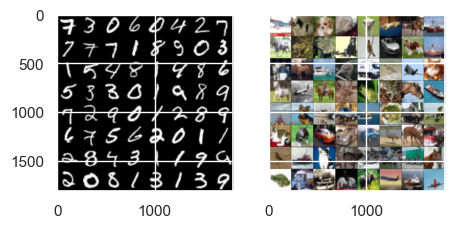

In [14]:
#Get a batch of training data from mnist and cifar
inputsM, classesM = next(iter(mnist_train_loader))
inputsC, classesC = next(iter(cifar_train_loader))
imageMax = min(64, BATCH_SIZE)

#Display sample images
imshow(utils.make_grid(inputsM[0:imageMax]), utils.make_grid(inputsC[0:imageMax]))

## 3. Prepare Models for Training

In [15]:
#Add early stop class, inspired by https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [16]:
#Traing method inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#modified to fit data structure, and keep trach of metrics accross epochs
def train_model(model, modelDict, dataloaders, num_epochs, noisy=True, epochPatience=2, minDelta=-.001):
    #get model, criterion, optimizer, scheduler from dictionary 
    since = time.time()
    model = model.to(device) 
    criterion = modelDict['criterion']
    optimizer = modelDict['optimizer']
    scheduler = modelDict['scheduler']

    #Set early stopper parameters
    early_stopper = EarlyStopper(patience=epochPatience, min_delta=minDelta)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0
    
    #Keep track of metrics from training
    metrics = pd.DataFrame(data=[],columns=['epoch','accuracy','loss','phase'])
    
    for epoch in range(num_epochs):
        if noisy:
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 10)

        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #Set model to training mode
            else:
                model.eval()   #Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #Zero the parameter gradients
                optimizer.zero_grad()

                #Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize for training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            #Show statistics for each epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            epoch_acc = (running_corrects.double()) / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            
            if noisy:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {min(epoch_acc,1.0):.4f}')
            
            #Track metrics for graphing
            metrics = pd.concat([metrics,pd.DataFrame(data=[[epoch,epoch_acc.item(),epoch_loss,phase]],columns=['epoch','accuracy','loss','phase'])], ignore_index=True)

            #Deep copy the model to keep track of the best one
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc

        if noisy:
            print("")
            
        if early_stopper.early_stop(epoch_loss):
            print("Training stopped on epoch",epoch,"because the loss has not decreased by more than",minDelta,"in",epochPatience,"epochs")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')
    print(f'Best Train Acc: {min(best_train_acc,1.0):4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

In [17]:
def create_resnet(numClasses):
    #Create base ResNet model
    model_temp = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_fts_temp = model_temp.fc.in_features
    model_temp.fc = torch.nn.Linear(num_fts_temp, numClasses)
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

### Example model creation, training

Epoch 0/5
----------
train Loss: 0.0670 Acc: 0.9804
val Loss: 0.0373 Acc: 0.9881

Epoch 1/5
----------
train Loss: 0.0215 Acc: 0.9932
val Loss: 0.0250 Acc: 0.9918

Epoch 2/5
----------
train Loss: 0.0086 Acc: 0.9975
val Loss: 0.0145 Acc: 0.9962

Epoch 3/5
----------
train Loss: 0.0046 Acc: 0.9991
val Loss: 0.0137 Acc: 0.9961

Epoch 4/5
----------
train Loss: 0.0033 Acc: 0.9995
val Loss: 0.0134 Acc: 0.9959

Epoch 5/5
----------
train Loss: 0.0030 Acc: 0.9995
val Loss: 0.0133 Acc: 0.9963

Training complete in 44m 37s
Best Val Acc: 0.996333
Best Train Acc: 0.999490


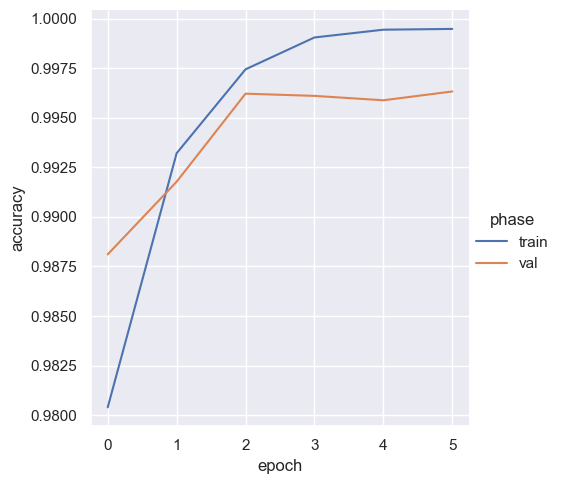

In [18]:
#Create model for dataset
resNet_mnist, resNet_mnist_dict = create_resnet(numClassesMnist)
 
#Load or train model
if(loadModels):
    resNet_mnist.load_state_dict(torch.load(modelFolderPath + 'model_resnet_mnist.pth'))
else:
    resNet_mnist, metrics_resNet_mnist = train_model(resNet_mnist, resNet_mnist_dict, dataloaders_mnist, EPOCHS)
    sns.relplot(data=metrics_resNet_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)

#Save model if needed
if(saveModels): 
    torch.save(resNet_mnist.state_dict(), modelFolderPath + 'model_resnet_mnist.pth')

Epoch 0/5
----------
train Loss: 0.4194 Acc: 0.8544
val Loss: 0.5000 Acc: 0.8348

Epoch 1/5
----------
train Loss: 0.2053 Acc: 0.9300
val Loss: 0.3399 Acc: 0.8856

Epoch 2/5
----------
train Loss: 0.0643 Acc: 0.9816
val Loss: 0.1698 Acc: 0.9429

Epoch 3/5
----------
train Loss: 0.0244 Acc: 0.9955
val Loss: 0.1651 Acc: 0.9455

Epoch 4/5
----------
train Loss: 0.0135 Acc: 0.9990
val Loss: 0.1648 Acc: 0.9455

Epoch 5/5
----------
train Loss: 0.0123 Acc: 0.9992
val Loss: 0.1637 Acc: 0.9464

Training complete in 32m 5s
Best Val Acc: 0.946400
Best Train Acc: 0.999200


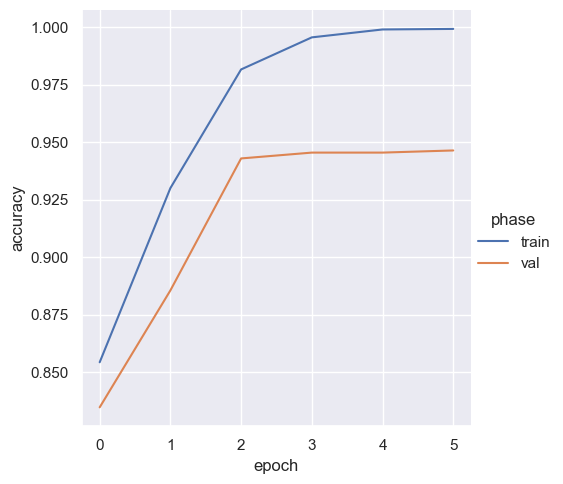

In [19]:
resNet_cifar, resNet_cifar_dict = create_resnet(numClassesCifar)
 
#Load or train model
if(loadModels):
    resNet_cifar.load_state_dict(torch.load(modelFolderPath + 'model_resnet_cifar.pth'))
else:
    resNet_cifar, metrics_resNet_cifar = train_model(resNet_cifar, resNet_cifar_dict, dataloaders_cifar, EPOCHS)
    sns.relplot(data=metrics_resNet_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)

if(saveModels): 
    torch.save(resNet_cifar.state_dict(), modelFolderPath + 'model_resnet_cifar.pth')

### Todo in this section: 
Philip - define create_mobilenet <br>
Philip - create and transfer learn/train 2 mobilenet base models <br>
Paul - define create_inception <br>
Paul - create and transfer learn/train 2 inception base models <br>

## 4.0 Test Base Models

In [20]:
def test_model(model, classes, test_loader):
    torch.cuda.empty_cache()
    #Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model = model.to(device)

    #Store additional prediction info for CF and graphs
    allLabels = []
    allPrediction = []
    testAccuracies = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            #Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label.item()] += 1
                total_pred[label.item()] += 1
                allLabels.append(label.item())
                allPrediction.append(prediction.item())

    #Get each class accuracy manually
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / (total_pred[classname] or 1)
        testAccuracies.append(accuracy)

    #Show overall acurracy
    print(f'Testing Overall Accuracy: {100.0*sum(correct_pred.values())/sum(total_pred.values()):4f} ')
    
    return  allLabels, allPrediction, testAccuracies

In [21]:
#Pass in the 3 metrics from test function, and options to create other graphs
def show_test_results(allLabels, allPrediction, testAccuracies, labelNames, cf=True, bar=True):
    if cf:
        #Show confusion matrix
        cf_matrix = confusion_matrix(allLabels, allPrediction)
        #Divide predicted columns by number predicted for each class
        ax = sns.heatmap((cf_matrix / np.sum(cf_matrix, axis=1)), fmt='.1%', xticklabels=labelNames, yticklabels=labelNames)
        ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
        ax.set_ylabel("Labeled Class", fontsize=14, labelpad=20)
        plt.show()
    
    if bar:
        #Format the label data for plotting class accuracies
        uniqueTest, countsTest = np.unique(allLabels, return_counts=True)
        labelDictTest = dict(zip(uniqueTest, countsTest))
        keysTest = list(labelDictTest.keys())
        labelsCountTest = [int(labelDictTest[k]) for k in keysTest]

        #Show class accuracies on barchart
        plot = sns.barplot(x=keysTest, y=testAccuracies)
        plot.set_xticklabels(labels=labelNames, rotation=-45)
        plt.show()

### Example Test Model

In [22]:
allLabels, allPrediction, testAccuracies = test_model(resNet_mnist, classesNumericMnist, mnist_test_loader)

Testing Overall Accuracy: 99.700000 


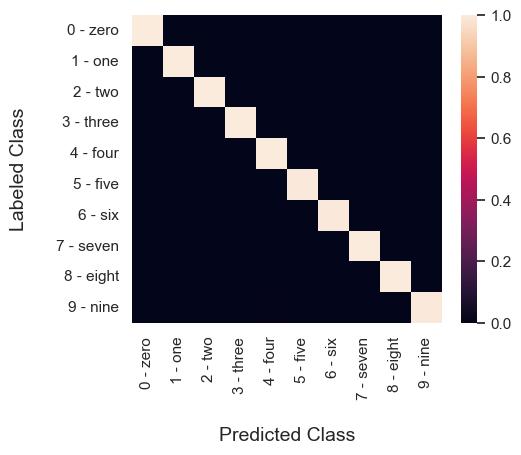

In [23]:
show_test_results(allLabels, allPrediction, testAccuracies, classesMnist, True, False)

In [24]:
allLabels, allPrediction, testAccuracies = test_model(resNet_cifar, classesNumericCifar, cifar_test_loader)

Testing Overall Accuracy: 94.660000 


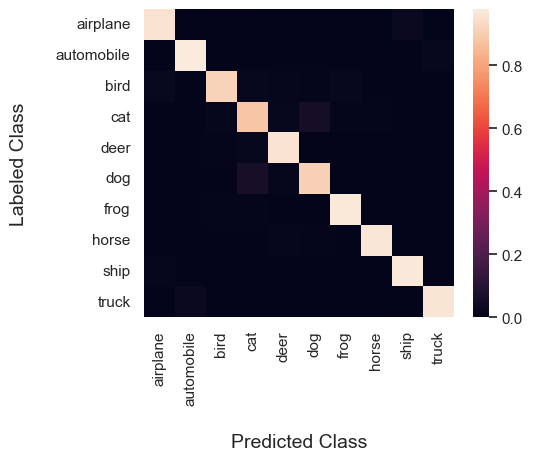

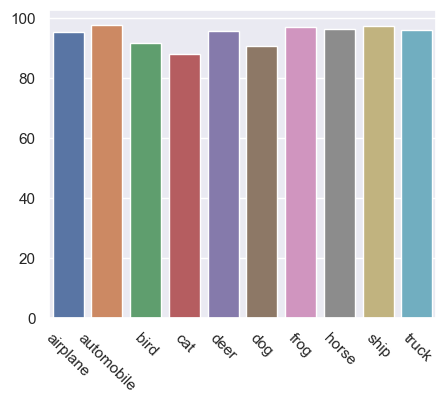

In [25]:
show_test_results(allLabels, allPrediction, testAccuracies, classesCifar, True, True)

### Philip Todo in this section: 
test remaining 4 base models <br>

## 5. Post Training Quantize Models - Philip Todo

## 6. Test Post Training Quantized Models - Philip Todo